In [1]:

import os
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
train_df = pd.read_csv("./input/train.csv")
train_df, val_df = train_test_split(train_df, test_size=0.1)

In [3]:
emb_index = {}
emb_file = open('./input/embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in tqdm(emb_file):
    emb_values = line.split(" ")
    word = emb_values[0]
    vecs = np.asarray(emb_values[1:], dtype='float32')
    emb_index[word] = vecs
emb_file.close()

print('Found %s word vectors.' % len(emb_index))

2196017it [01:45, 20866.79it/s]

Found 2196016 word vectors.


In [4]:
TIME_STEP = 30
EMB_VEC_SIZE = 300
BATCH_SIZE = 128
def text_to_vec(text):
    init_emb = np.zeros(EMB_VEC_SIZE)
    text = text[:-1].split()[:TIME_STEP]
    embeds = [emb_index.get(x, init_emb) for x in text]
    embeds+= [init_emb] * (TIME_STEP - len(embeds))
    return np.array(embeds)


In [5]:

def train_gen(train_df, shuffle=False):
    n_batches = math.ceil(len(train_df) / BATCH_SIZE)
    while True: 
        if(shuffle==True):
            train_df = train_df.sample(frac=1.)  # Shuffle the data.
        for i in range(n_batches):
            texts = train_df.iloc[i*BATCH_SIZE:(i+1)*BATCH_SIZE, 1]
            text_arr = np.array([text_to_vec(text) for text in texts])
            yield text_arr, np.array(train_df["target"][i*BATCH_SIZE:(i+1)*BATCH_SIZE])

In [6]:
from keras.models import  Model
from keras.layers import LSTM, Dense, Bidirectional, Input, CuDNNLSTM
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [7]:
def get_available_gpus():
        local_device_protos = device_lib.list_local_devices()
        return [x.name for x in local_device_protos if x.device_type == 'GPU']
    
def get_base_model(input):

  num_gpus = get_available_gpus()
  #print(len(num_gpus))
  #Build LSTM network

  if(len(num_gpus)>0):
    first_lstm = Bidirectional(CuDNNLSTM(64, return_sequences=True, name='lstm1'))(input)
    second_lstm = Bidirectional(CuDNNLSTM(64, name='lstm2'))(first_lstm)
  else:  
    first_lstm = Bidirectional(LSTM(64, return_sequences=True, name='lstm1'))(input)
    second_lstm = Bidirectional(LSTM(64, name='lstm2'))(first_lstm)
  outputs = Dense(1, activation="sigmoid", name='last')(second_lstm)
  
  #create model LSTM+dense
  l_model = Model(input, outputs) 
  
  return(l_model)

In [8]:
features = Input(shape=(TIME_STEP, EMB_VEC_SIZE))
model = get_base_model(features)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:

train_generator = train_gen(train_df, True)
validation_generator = train_gen(val_df, False)
model.fit_generator(train_generator,
                    steps_per_epoch=int(len(train_df) / BATCH_SIZE),
                    validation_data=validation_generator,
                    validation_steps = int(len(val_df) / BATCH_SIZE),
                    epochs=1,
                    verbose=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
9183/9183 [==============================] - 760s 83ms/step - loss: 0.1135 - acc: 0.9554 - val_loss: 0.1038 - val_acc: 0.9590


In [10]:
def test_gen(train_df):
    n_batches = math.ceil(len(train_df) / BATCH_SIZE)
    for i in range(n_batches):
            texts = train_df.iloc[i*BATCH_SIZE:(i+1)*BATCH_SIZE, 1]
            text_arr = np.array([text_to_vec(text) for text in texts])
            yield text_arr, np.array(train_df["target"][i*BATCH_SIZE:(i+1)*BATCH_SIZE])

In [11]:
y_test = []
y_preds = []
for x, y in tqdm(test_gen(val_df)):
    y_preds.extend(model.predict(x))
    y_test.extend(y)

1021it [01:01, 16.54it/s]


In [12]:
y1 = np.array(y_preds)
y2 = np.array(y_test)
y11 = y1.squeeze()
y1 = y11 > 0.5
y1 = y1.astype(np.int)        
score = f1_score(y2, y1)
print(score)    

0.6432515133373246


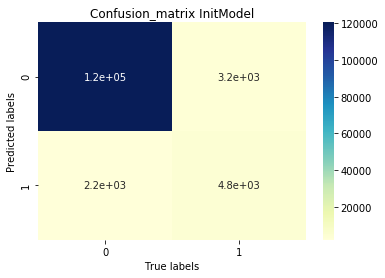

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def get_confusion_matrix(test_y, pred,title):
    cm=confusion_matrix(pred,test_y)
   
    fig = plt.figure()
    sns.heatmap(cm, cmap='YlGnBu', annot=True)
    plt.title(title)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()
    fig.savefig('InitModel_confusion_matrix')
 
get_confusion_matrix(y2,y1,'Confusion_matrix InitModel')    

In [15]:
from sklearn.metrics import recall_score, precision_score
r = recall_score(y2, y1, average='binary')
p = precision_score(y2, y1, average='binary')
print('Precision: {:.3f} Recall: {:.3f}'.format(p, r))

Precision: 0.691 Recall: 0.601
